In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from data_model import create_dataloaders
from train_eval import train_epoch, eval_epoch
from utils import accuracy, set_seeds
from LSTM_model import ArtikelLSTM
from Transformer_model import ArtikelTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

gender_to_idx = {"masculine": 0, "feminine": 1, "neutral": 2}
artikel_to_idx = {"der": 0, "die": 1, "das": 2}

In [2]:
set_seeds(seed=42)
writer = SummaryWriter()

In [3]:
train_dataloader, test_dataloader = create_dataloaders(file_path="words_big.txt", data_fraction=0.2, test_size=0.2, batch_size=64)

Words with der: 22485, words with die: 28411, words with das: 14364
31


In [4]:
model = ArtikelLSTM(vocab_size=31, embedding_dim=32, hidden_dim=8, dropout=0.8, num_layers=1)
#model = ArtikelTransformer(vocab_size=31, embedding_dim=8, num_heads=4, hidden_dim=16, num_layers=4)
model.to(device)

_ = summary(model, input_size=(1, 10), dtypes=[torch.long], col_names=["input_size", "output_size", "num_params", "trainable", "mult_adds"], col_width=20, row_settings=["var_names"], verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable            Mult-Adds
ArtikelLSTM (ArtikelLSTM)                [1, 10]              [1, 3]               --                   True                 --
├─Embedding (embedding)                  [1, 10]              [1, 10, 32]          992                  True                 992
│    └─weight                                                                      └─992
├─LSTM (lstm)                            [1, 10, 32]          [1, 10, 16]          2,688                True                 26,880
│    └─weight_ih_l0                                                                ├─1,024
│    └─weight_hh_l0                                                                ├─256
│    └─bias_ih_l0                                                                  ├─32
│    └─bias_hh_l0                                                                  ├─32
│    └─weight_ih_l0_reverse    

C:\Users\Tomek\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []

In [6]:
# Training loop
#add_text("")

for epoch in range(5):  # Number of epochs
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
    test_loss, test_accuracy = eval_epoch(model, test_dataloader, loss_fn, device)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', test_accuracy, epoch)
    
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss.cpu())
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}, Train_loss: {train_loss.item():.4f}, Test_loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.4f}")

Epoch 1, Train_loss: 0.8536, Test_loss: 0.7459, Accuracy: 66.3266
Epoch 2, Train_loss: 0.7237, Test_loss: 0.6932, Accuracy: 70.7685
Epoch 3, Train_loss: 0.6864, Test_loss: 0.6734, Accuracy: 71.7489
Epoch 4, Train_loss: 0.6604, Test_loss: 0.6376, Accuracy: 74.0171
Epoch 5, Train_loss: 0.6145, Test_loss: 0.5956, Accuracy: 76.2393


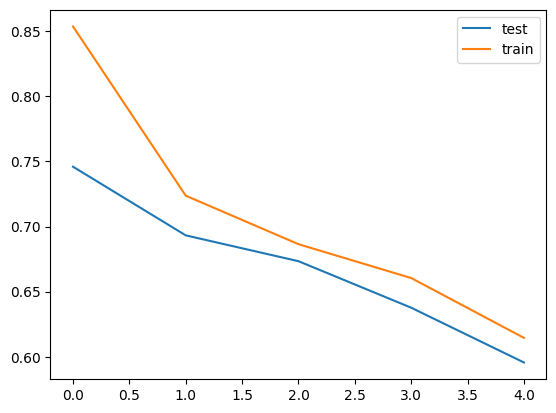

In [7]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

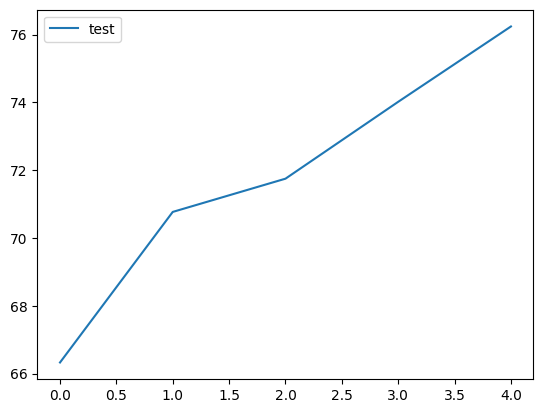

In [8]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

In [9]:
def predict(model, word, char_to_idx):
    model.eval()
    word_indices = [char_to_idx[char] for char in word.lower()]
    word_tensor = torch.tensor(word_indices, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(word_tensor)

        idx = torch.argmax(output, dim=1).item()

    idx_to_artikel = {v: k for k, v in artikel_to_idx.items()}

    return idx_to_artikel[idx]

# Example usage
print(predict(model, "Popo", char_to_idx))

NameError: name 'char_to_idx' is not defined